<a href="https://colab.research.google.com/github/jhsam007/Twitter-Emotion-Recognition-Natural-Language-Processing-with-Tensorflow/blob/main/Twitter_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Emotion Recognition: Natural Language Processing with Tensorflow

In [34]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [149]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

# Import Data

In [150]:
dataset = nlp.load_dataset('emotion')

In [151]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [152]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [153]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [154]:
tweets, labels = get_tweet(train)

In [155]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

# Tokenizer

In [156]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [157]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

In [158]:
tokenizer.texts_to_sequences([tweets[1]])

[[2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

# Checking Length and Creating Padded Sequence

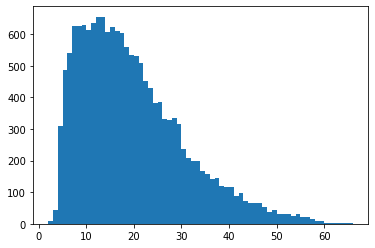

In [159]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [160]:
maxlen = 60
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [161]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [162]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [163]:
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

# Labels

In [164]:
classes = set(labels)
print(classes)

{'joy', 'anger', 'surprise', 'fear', 'sadness', 'love'}


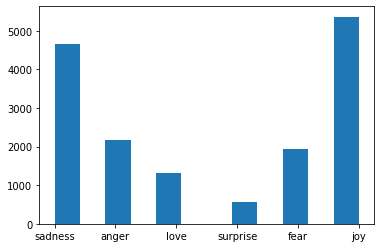

In [165]:
plt.hist(labels, bins=12)
plt.show()

In [166]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [167]:
class_to_index

{'anger': 1, 'fear': 3, 'joy': 0, 'love': 5, 'sadness': 4, 'surprise': 2}

In [168]:
index_to_class

{0: 'joy', 1: 'anger', 2: 'surprise', 3: 'fear', 4: 'sadness', 5: 'love'}

In [169]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [170]:
train_labels = names_to_ids(labels)
print(train_labels[0])

4


# Model

In [178]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=60),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [179]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 60, 16)            160000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 60, 40)           5920      
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [180]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [181]:
val_tweets[5], val_labels[5]

('i start to feel more appreciative of what god has done for me', 0)

In [182]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 11s 15ms/step - loss: 1.3702 - accuracy: 0.4505 - val_loss: 1.0907 - val_accuracy: 0.5835
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.7447 - accuracy: 0.7154 - val_loss: 0.6760 - val_accuracy: 0.7760
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.4374 - accuracy: 0.8485 - val_loss: 0.5180 - val_accuracy: 0.8295
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2738 - accuracy: 0.9146 - val_loss: 0.4477 - val_accuracy: 0.8630
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1917 - accuracy: 0.9424 - val_loss: 0.4192 - val_accuracy: 0.8790
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1554 - accuracy: 0.9531 - val_loss: 0.3968 - val_accuracy: 0.8830
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1184 - accuracy: 0.9639 - val_loss: 0.4259 - val_accuracy: 0.891

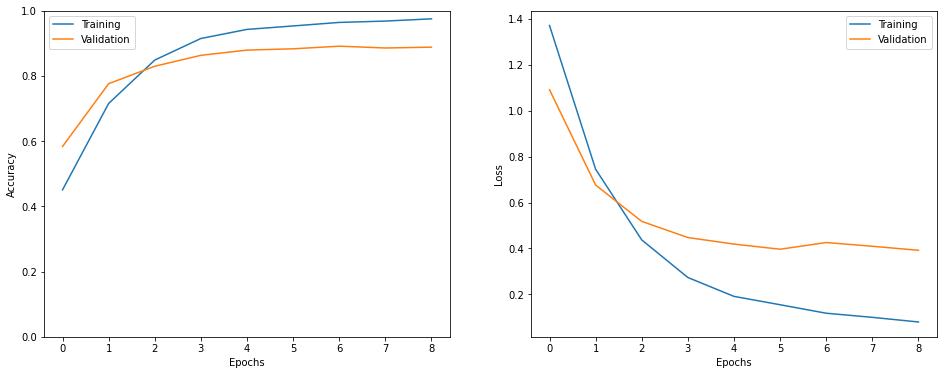

In [183]:
show_history(h)

In [184]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [185]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.3853 - accuracy: 0.8860


In [186]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i was stupid and said yes which made me feel idiotic because i didnt stick to my guns and do what i had set out to do
Emotion: sadness
Predicted Emotion: sadness


In [187]:
preds = np.argmax(model.predict(test_seq),axis=-1)

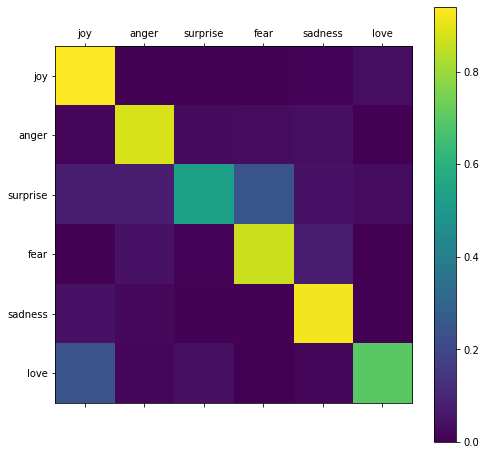

In [188]:
show_confusion_matrix(test_labels, preds, list(classes))